In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/MyDrive"

In [ ]:

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import os

In [ ]:
with open(os.path.join(base_dir, 'Lexical Model', 'paper_attended_reviews_ICLR_2018.pkl'), 'rb') as fr:
    final_paper_attended_reviews = pkl.load(fr)

In [ ]:
# Load labels from excel
labels_df = pd.read_csv(os.path.join(base_dir, 'Lexical Model', 'data_latest_final2.csv'))

In [ ]:
labels_df["paper_name"]

0       ICLR2018-B11bwYgfM-R1_annotated
1       ICLR2018-B11bwYgfM-R2_annotated
2       ICLR2018-B11bwYgfM-R3_annotated
3       ICLR2018-B12Js_yRb-R1_annotated
4       ICLR2018-B12Js_yRb-R2_annotated
                     ...               
1199    ICLR2018-SyVOjfbRb-R2_annotated
1200    ICLR2018-SyVOjfbRb-R3_annotated
1201    ICLR2018-SyXNErg0W-R1_annotated
1202    ICLR2018-SyXNErg0W-R2_annotated
1203    ICLR2018-SyXNErg0W-R3_annotated
Name: paper_name, Length: 1204, dtype: object

In [ ]:
for name in final_paper_attended_reviews['paper_review_name'][:5]:
  print(name)

ICLR2018-B13EC5u6W-R2
ICLR2018-B13EC5u6W-R3
ICLR2018-B13EC5u6W-R1
ICLR2018-B16_iGWCW-R2
ICLR2018-B16_iGWCW-R3


In [ ]:
scores_df = pd.read_csv(os.path.join(base_dir, "Lexical Model", 'review_scores.csv'))

In [ ]:
scores_df.columns

Index(['avg_syllable_count', 'avg_wordlength', 'avg_sentlengthbyword',
       'count_functionalwords', 'punctuation_count_ratio', 'fleschreadingease',
       'yulek', 'maas', 'msttr', 'mattr', 'sem_spread', 'review_name'],
      dtype='object')

In [ ]:
scores_df

,avg_syllable_count,avg_wordlength,avg_sentlengthbyword,count_functionalwords,punctuation_count_ratio,fleschreadingease,yulek,maas,msttr,mattr,sem_spread,review_name
0,1.426506,6.670330,10.375000,0.328502,0.029335,47.084640,138.952091,0.018348,0.923077,0.933508,0.161313,ICLR2018-B12Js_yRb-R2.txt
1,1.518519,7.304598,22.500000,0.335878,0.016160,36.581188,146.504015,0.019886,0.917647,0.916599,0.171135,ICLR2018-B12Js_yRb-R3.txt
2,1.351967,6.259494,16.100000,0.313305,0.032826,63.236203,127.181909,0.018407,0.933333,0.932720,0.175363,ICLR2018-B12Js_yRb-R1.txt
3,1.378472,6.525510,20.571429,0.332143,0.024825,47.908313,94.780508,0.015155,0.962963,0.955725,0.204565,ICLR2018-B13njo1R--R2.txt
4,1.270408,5.668790,14.341463,0.448041,0.024288,52.005353,123.336227,0.019689,0.945614,0.934520,0.190831,ICLR2018-B13njo1R--R1.txt
...,...,...,...,...,...,...,...,...,...,...,...,...
2436,1.547264,6.916115,13.704545,0.250831,0.039892,43.166916,76.518948,0.013844,0.953153,0.955395,0.205214,ICLR2018-ryykVe-0W-R3.txt
2437,1.400545,7.052381,21.588235,0.393443,0.020021,35.749189,119.753086,0.017845,0.950725,0.937380,0.182217,ICLR2018-ryykVe-0W-R2.txt
2438,1.432258,7.313953,22.142857,0.364238,0.022195,53.749784,154.947975,0.019692,0.918519,0.910617,0.191121,ICLR2018-ryzm6BATZ-R3.txt
2439,1.453608,6.830508,19.400000,0.374570,0.022124,31.588185,181.688466,0.019891,0.922807,0.915217,0.171482,ICLR2018-ryzm6BATZ-R1.txt


In [ ]:
# Load the data
# data = torch.cat(final_paper_attended_reviews['paper_attended_review'])
data = []
# labels = torch.randn(159, 1)
# labels = torch.tensor(labels_df["informativeness_score"]).reshape(-1, 1)
labels = []

review_names = final_paper_attended_reviews['paper_review_name']

for i, name in enumerate(review_names):
    row = labels_df[labels_df["paper_name"].str.contains(name)]
    if not row.empty:
        informativeness_score = row["informativeness_score"].iloc[0]
        labels.append(informativeness_score)
        data.append(final_paper_attended_reviews['paper_attended_review'][i])

data = torch.cat(data)
labels = torch.tensor(labels).reshape(-1, 1)

print(data.shape)
print(labels.shape)

# Initialize an empty list to store the scores
data_scores = []

# Iterate over the review names
for i, name in enumerate(review_names):
    # Find the row in scores_df that contains the review name
    row = scores_df[scores_df["review_name"].str.contains(name)]

    # If the row is not empty
    if not row.empty:
        # Append the scores to the data_scores list
        data_scores.append(row.iloc[0].tolist()[:-1])  # Assuming scores start from the second column

# Create a dataframe from the data_scores list
data_scores_df = pd.DataFrame(data_scores, columns=scores_df.columns[:-1])

# Print the shape of the new dataframe
print(data_scores_df.shape)

torch.Size([570, 512, 768])
torch.Size([570, 1])
(570, 11)


In [ ]:
batch_size = 32
split_ratio = 0.2
data_size = data.size(0)
split_size = int(split_ratio * data_size)

# Convert the scores dataframe to a tensor
data_scores_tensor = torch.tensor(data_scores_df.values)

# Split the data into train and test sets
train_data, test_data = data.split((data_size - split_size, split_size))
train_scores, test_scores = data_scores_tensor.split((data_size - split_size, split_size))
train_labels, test_labels = labels.split((data_size - split_size, split_size))

# Create data loaders for training and testing
train_loader = DataLoader(TensorDataset(train_data, train_scores, train_labels), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data, test_scores, test_labels), batch_size=batch_size)

print(train_data.shape)
print(train_scores.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_scores.shape)
print(test_labels.shape)

torch.Size([456, 512, 768])
torch.Size([456, 11])
torch.Size([456, 1])
torch.Size([114, 512, 768])
torch.Size([114, 11])
torch.Size([114, 1])


In [ ]:
class BiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, score_size):
        super(BiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size*2 + score_size, 256)  # 2 for bidirection
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(dropout)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x, scores):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirection
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = torch.cat((out, scores), dim=1)  # Concatenate the GRU output and scores
        out = self.fc1(out)
        out = torch.relu(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = torch.relu(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = torch.relu(out)
        out = self.dropout3(out)
        out = self.fc4(out)
        out = torch.sigmoid(out)
        return out


In [ ]:
# Alternative arch
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, score_size):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size*2, 256)  # 2 for bidirection
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32 + score_size, 16)
        self.bn5 = nn.BatchNorm1d(16)
        self.fc6 = nn.Linear(16, 1)

    def forward(self, x, scores):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirection
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirection
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        elu = torch.nn.ELU()
        out = self.fc1(out)
        out = self.bn1(out)
        out = elu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = elu(out)
        out = self.fc3(out)
        out = self.bn3(out)
        out = elu(out)
        out = self.fc4(out)
        out = self.bn4(out)
        out = elu(out)
        out = torch.cat((out, scores), dim=1)  # Concatenate the fc4 output and scores
        out = self.fc5(out)
        out = self.bn5(out)
        out = elu(out)
        out = self.fc6(out)
        # out = torch.sigmoid(out)
        return out

In [ ]:
data.dtype

torch.float32

In [ ]:
data_scores_tensor.dtype

torch.float64

In [ ]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
len(data_scores_df.columns)

11

In [ ]:
# Initialize the model
# model = BiGRU(768, 512, 3, 0.5).to(device)
model = BiLSTM(768, 512, 3, 0.5, len(data_scores_df.columns)).to(device)

# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.HuberLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [ ]:
# Training loop 768, 512, 3, 0.5, additionally fc layer, with non-linear activations (elu) bilstm, last layer sigmoid
num_epochs = 50
best_loss = float('inf')
train_loss_values, train_r2_values, train_mae_values, train_mse_values, train_rmse_values = [], [], [], [], []
test_loss_values, test_r2_values, test_mae_values, test_mse_values, test_rmse_values = [], [], [], [], []
for epoch in range(num_epochs):
    model.train()
    train_outputs = []
    train_labels = []
    for batch_data, batch_scores, batch_labels in train_loader:
        batch_data, batch_scores, batch_labels = batch_data.float().to(device), batch_scores.float().to(device), batch_labels.float().to(device)
        outputs = model(batch_data, batch_scores)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_outputs.append(outputs.detach().cpu().numpy())
        train_labels.append(batch_labels.cpu().numpy())

    train_outputs = np.concatenate(train_outputs)
    train_labels = np.concatenate(train_labels)
    train_loss = criterion(torch.tensor(train_outputs), torch.tensor(train_labels)).item()
    train_r2 = r2_score(train_labels, train_outputs)
    train_mae = mean_absolute_error(train_labels, train_outputs)
    train_mse = mean_squared_error(train_labels, train_outputs)
    train_rmse = math.sqrt(train_mse)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Train R2 Score: {train_r2}, Train MAE: {train_mae}, Train MSE: {train_mse}, Train RMSE: {train_rmse}')

    # Save metrics
    train_loss_values.append(train_loss)
    train_r2_values.append(train_r2)
    train_mae_values.append(train_mae)
    train_mse_values.append(train_mse)
    train_rmse_values.append(train_rmse)

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = []
        test_labels = []
        for batch_data, batch_scores, batch_labels in test_loader:
            batch_data, batch_scores, batch_labels = batch_data.float().to(device), batch_scores.float().to(device), batch_labels.float().to(device)
            batch_outputs = model(batch_data, batch_scores)
            test_outputs.append(batch_outputs.detach().cpu().numpy())
            test_labels.append(batch_labels.cpu().numpy())
        test_outputs = np.concatenate(test_outputs)
        test_labels = np.concatenate(test_labels)
        test_loss = criterion(torch.tensor(test_outputs), torch.tensor(test_labels)).item()
        test_r2 = r2_score(test_labels, test_outputs)
        test_mae = mean_absolute_error(test_labels, test_outputs)
        test_mse = mean_squared_error(test_labels, test_outputs)
        test_rmse = math.sqrt(test_mse)

    print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss}, Test R2 Score: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}, Test RMSE: {test_rmse}')

    # Save the best model
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), os.path.join(base_dir, "Lexical Model", 'best_model_lexical_new1.pth'))
        with open(os.path.join(base_dir, "Lexical Model", 'losses_and_errors_best_lexical_new1.pkl'), "wb") as f:
            pkl.dump({
                "train_loss": train_loss,
                "train_r2": train_r2,
                "train_mae": train_mae,
                "train_mse": train_mse,
                "train_rmse": train_rmse,
                "test_loss": test_loss,
                "test_r2": test_r2,
                "test_mae": test_mae,
                "test_mse": test_mse,
                "test_rmse": test_rmse
            }, f)

    # Adjust the learning rate
    scheduler.step(test_loss)

    # Save metrics
    test_loss_values.append(test_loss)
    test_r2_values.append(test_r2)
    test_mae_values.append(test_mae)
    test_mse_values.append(test_mse)
    test_rmse_values.append(test_rmse)

with open(os.path.join(base_dir, "Lexical Model", 'losses_and_errors_train_test_lexical_new1.pkl'), "wb") as f:
    pkl.dump({
        "train_loss": train_loss_values,
        "train_r2": train_r2_values,
        "train_mae": train_mae_values,
        "train_mse": train_mse_values,
        "train_rmse": train_rmse_values,
        "test_loss": test_loss_values,
        "test_r2": test_r2_values,
        "test_mae": test_mae_values,
        "test_mse": test_mse_values,
        "test_rmse": test_rmse_values
    }, f)


Epoch 1/50, Train Loss: 0.16357800364494324, Train R2 Score: -46.45422911734069, Train MAE: 0.5367497801780701, Train MSE: 0.32744958996772766, Train RMSE: 0.5722321119683232
Epoch 1/50, Test Loss: 0.2645256519317627, Test R2 Score: -77.74114592861594, Test MAE: 0.71571284532547, Test MSE: 0.5290513038635254, Test RMSE: 0.727359129910064
Epoch 2/50, Train Loss: 0.11605412513017654, Train R2 Score: -32.637295192328565, Train MAE: 0.4635731875896454, Train MSE: 0.23210826516151428, Train RMSE: 0.48177615669677376
Epoch 2/50, Test Loss: 0.23392106592655182, Test R2 Score: -68.63110036547063, Test MAE: 0.6729564070701599, Test MSE: 0.46784210205078125, Test RMSE: 0.6839898406049473
Epoch 3/50, Train Loss: 0.08692937344312668, Train R2 Score: -24.195734308394645, Train MAE: 0.3976704180240631, Train MSE: 0.17385874688625336, Train RMSE: 0.41696372370537627
Epoch 3/50, Test Loss: 0.18500609695911407, Test R2 Score: -54.07061926628857, Test MAE: 0.5943911075592041, Test MSE: 0.370012193918228

In [ ]:
# Load the saved metrics
with open(os.path.join(base_dir, "Lexical Model", 'losses_and_errors_best_lexical_new.pkl'), "rb") as f:
    model_metrics = pkl.load(f)

model_metrics

{'train_loss': 0.0045620147138834,
 'train_r2': -0.32226080937042245,
 'train_mae': 0.08064496,
 'train_mse': 0.0091240285,
 'train_rmse': 0.0955197806553398,
 'test_loss': 0.004138902761042118,
 'test_r2': -0.23202386105066397,
 'test_mae': 0.0769316,
 'test_mse': 0.008277805,
 'test_rmse': 0.09098244111234685}

In [ ]:
# Load the saved metrics (changed position of appending scores vector)
with open(os.path.join(base_dir, "Lexical Model", 'losses_and_errors_best_lexical_new.pkl'), "rb") as f:
    model_metrics = pkl.load(f)

model_metrics

{'train_loss': 0.0049307337030768394,
 'train_r2': -0.4291309556194167,
 'train_mae': 0.08604838,
 'train_mse': 0.009861468,
 'train_rmse': 0.09930492604839024,
 'test_loss': 0.004181484691798687,
 'test_r2': -0.2446993846542398,
 'test_mae': 0.07234552,
 'test_mse': 0.008362969,
 'test_rmse': 0.09144927218735736}

In [ ]:
# Load the saved metrics
with open(os.path.join(base_dir, "Lexical Model", 'losses_and_errors_best_lexical_new1.pkl'), "rb") as f:
    model_metrics = pkl.load(f)

model_metrics

{'train_loss': 0.004357198718935251,
 'train_r2': -0.262896827664147,
 'train_mae': 0.07676822,
 'train_mse': 0.008714397,
 'train_rmse': 0.0933509369951395,
 'test_loss': 0.007577921729534864,
 'test_r2': -1.2557141711045956,
 'test_mae': 0.09976753,
 'test_mse': 0.015155844,
 'test_rmse': 0.12310907517479085}

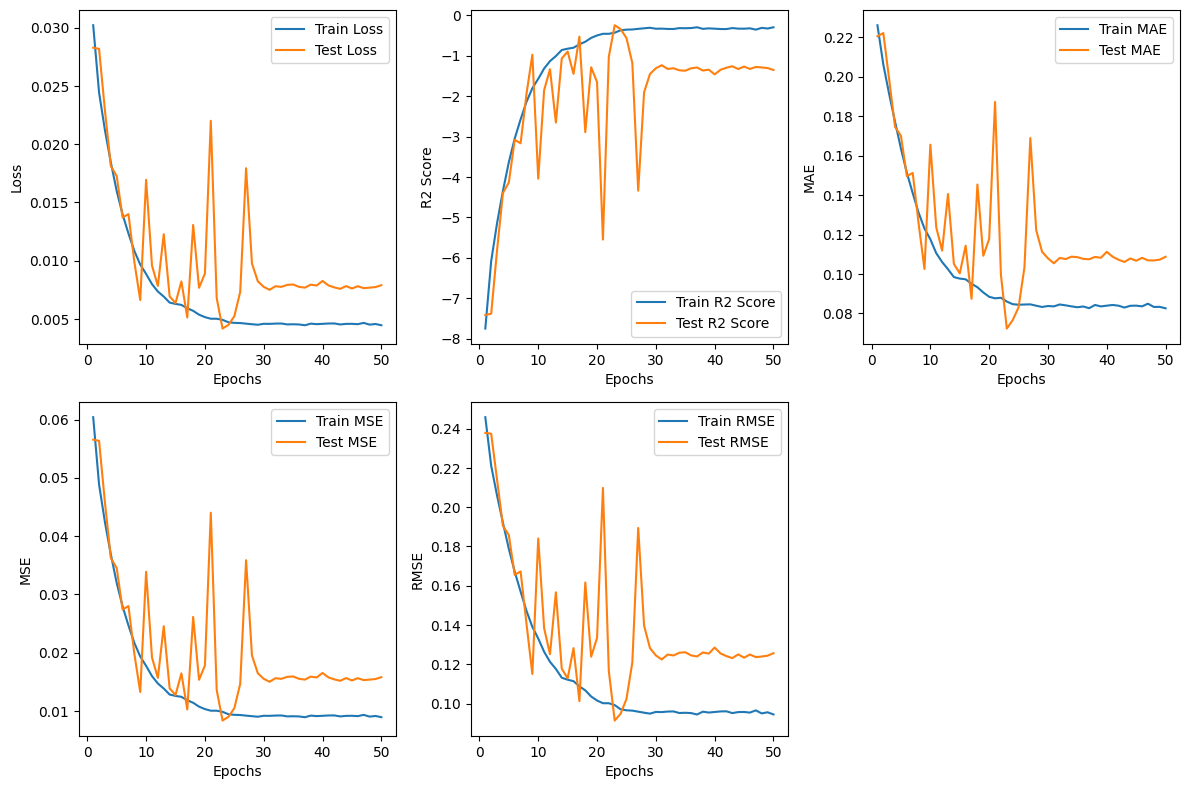

In [ ]:
# Load the saved metrics
with open(os.path.join(base_dir, "Lexical Model", 'losses_and_errors_train_test_lexical_new.pkl'), "rb") as f:
    metrics = pkl.load(f)

# Extract the metrics
train_loss_values = metrics['train_loss']
train_r2_values = metrics['train_r2']
train_mae_values = metrics['train_mae']
train_mse_values = metrics['train_mse']
train_rmse_values = metrics['train_rmse']
test_loss_values = metrics['test_loss']
test_r2_values = metrics['test_r2']
test_mae_values = metrics['test_mae']
test_mse_values = metrics['test_mse']
test_rmse_values = metrics['test_rmse']

# Plotting
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_values, label='Train Loss')
plt.plot(epochs, test_loss_values, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, train_r2_values, label='Train R2 Score')
plt.plot(epochs, test_r2_values, label='Test R2 Score')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs, train_mae_values, label='Train MAE')
plt.plot(epochs, test_mae_values, label='Test MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, train_mse_values, label='Train MSE')
plt.plot(epochs, test_mse_values, label='Test MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs, train_rmse_values, label='Train RMSE')
plt.plot(epochs, test_rmse_values, label='Test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()


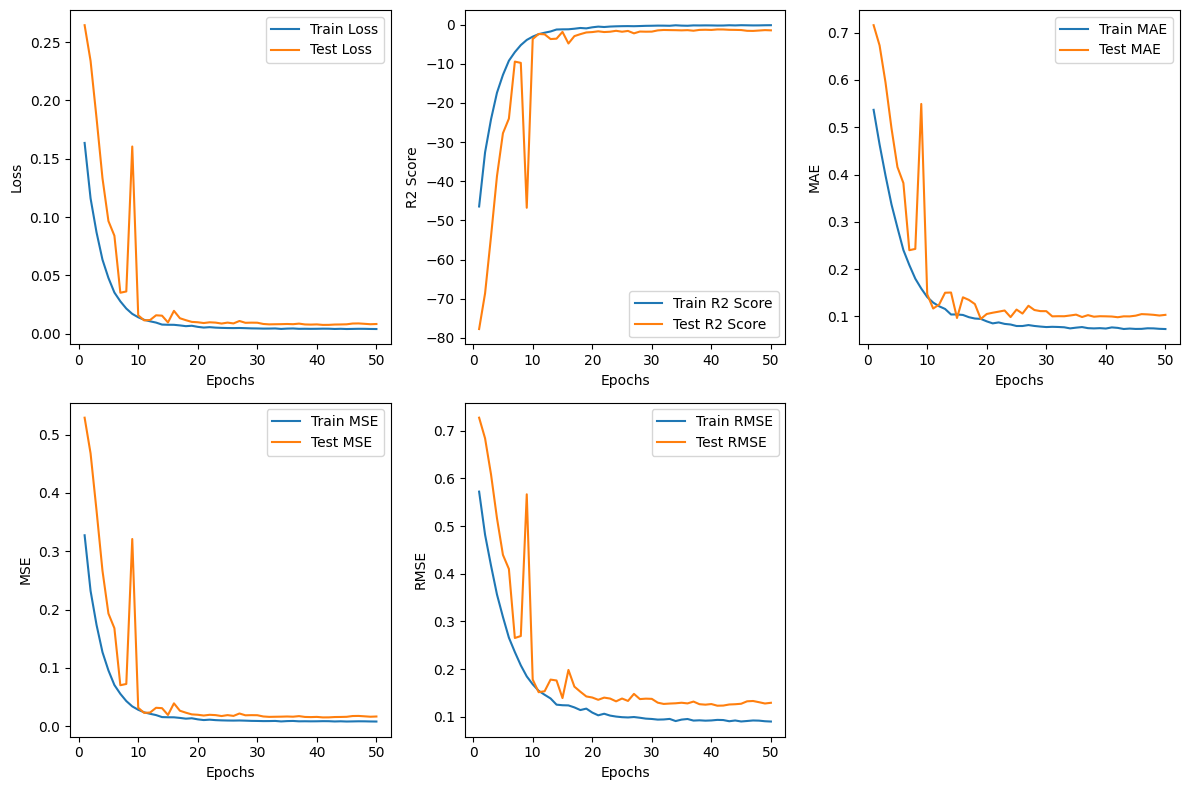

In [ ]:
# Load the saved metrics
with open(os.path.join(base_dir, "Lexical Model", 'losses_and_errors_train_test_lexical_new1.pkl'), "rb") as f:
    metrics = pkl.load(f)

# Extract the metrics
train_loss_values = metrics['train_loss']
train_r2_values = metrics['train_r2']
train_mae_values = metrics['train_mae']
train_mse_values = metrics['train_mse']
train_rmse_values = metrics['train_rmse']
test_loss_values = metrics['test_loss']
test_r2_values = metrics['test_r2']
test_mae_values = metrics['test_mae']
test_mse_values = metrics['test_mse']
test_rmse_values = metrics['test_rmse']

# Plotting
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_values, label='Train Loss')
plt.plot(epochs, test_loss_values, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, train_r2_values, label='Train R2 Score')
plt.plot(epochs, test_r2_values, label='Test R2 Score')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs, train_mae_values, label='Train MAE')
plt.plot(epochs, test_mae_values, label='Test MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, train_mse_values, label='Train MSE')
plt.plot(epochs, test_mse_values, label='Test MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs, train_rmse_values, label='Train RMSE')
plt.plot(epochs, test_rmse_values, label='Test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()
